In [208]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import catboost
import json

from razdel import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from catboost import CatBoostRegressor, CatBoostClassifier

%matplotlib inline

In [238]:
def decode_punkt(punkt_code):
    punkt_code = int(punkt_code)
    if punkt_code == 1:
        next_punkt='.'
    elif punkt_code == 2:
        next_punkt=','
    elif punkt_code == 3:
        next_punkt=':'
    elif punkt_code == 4:
        next_punkt=';'
    elif punkt_code == 5:
        next_punkt='!'
    elif punkt_code == 6:
        next_punkt='?'
    elif punkt_code == 11:
        next_punkt='...'
    elif punkt_code == 12:
        next_punkt='-'
    elif punkt_code == 13:
        next_punkt='-'
    return next_punkt


def load_xml(path):
    data_xml = ET.parse(path)
    root = data_xml.getroot()

    for child in root.findall('text/sentence/word'):
        print(child.tag, child.attrib, child.text)
    sentences = root.findall('.//sentence')
    dataset = []
    sentagma_id=0
    for sen in sentences:
        words_list = []
        nucleus = []
        pause = []
        sent = []
        # next_punkt=''
        for item in  sen: #.findall('word'):
            #print(item.tag, item.attrib, item.text)
            if item.tag == 'word':
                if 'original' not in item.attrib:
                    #print(item.tag, item.attrib, item.text)
                    nucleus[-1] = nucleus[-1] or (False if 'nucleus' not in item.attrib else int(item.attrib['nucleus'])==2)
                    continue
                words_list.append(item.attrib['original'])
                nucleus.append(False if 'nucleus' not in item.attrib else int(item.attrib['nucleus'])==2)
                pause.append(0)
                sent.append(sentagma_id)
                # if next_punkt:
                #     words_list.append(next_punkt)
                #     nucleus.append(False)
                #     pause.append(0)
                #     next_punkt=''
            elif item.tag == 'pause':
                pause[-1] = int(item.attrib['time'])
                sentagma_id+=1
            # elif item.tag == 'content' and 'PunktEnd' in item.attrib:
            #     next_punkt = decode_punkt(item.attrib['PunktEnd'])
        df = pd.DataFrame({'words': words_list, 'nucleus': nucleus, 'pause': pause, 'sent': sent})
        dataset.append(df)
        #print(df)
        #break
    return pd.concat(dataset)
dataset_df = load_xml('data/jokes1.xml')

In [235]:
dataset_df.head(18)

,words,nucleus,pause,sent,tokenized
0,Друзья,False,0,0,[Друзья]
1,"мои,",True,151,0,"[мои, ,]"
2,чтобы,False,0,1,[чтобы]
3,соответствовать,True,0,1,[соответствовать]
4,"вам,",False,302,1,"[вам, ,]"
5,я,False,0,2,[я]
6,готов,False,0,2,[готов]
7,сделать,False,0,2,[сделать]
8,над,False,0,2,[над]
9,собой,False,0,2,[собой]


(array([2.41189e+05, 2.68380e+04, 9.52700e+03, 6.79300e+03, 2.03300e+03,
        1.78100e+04, 0.00000e+00, 4.61000e+02, 1.70000e+01, 1.00000e+00]),
 array([   0. ,  187.9,  375.8,  563.7,  751.6,  939.5, 1127.4, 1315.3,
        1503.2, 1691.1, 1879. ]),
 <BarContainer object of 10 artists>)

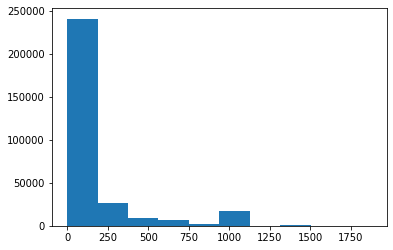

In [6]:
plt.hist(dataset_df['pause'])

In [132]:
def convert_to_tokenized(df):
    df['tokenized'] = df.apply(lambda row: [w.text for w in tokenize(row['words'])], axis=1)
    sents=[None]*(df['sent'].max()+1)
    sent2pause=[0]*len(sents)
    sent2n_word=[-1]*len(sents)
    for i, group in df.groupby('sent'):
        #print(i, group)
        sent2pause[i] = group['pause'].iloc[-1]
        #t = g
        #print(t)
        sents[i] = np.concatenate(group['tokenized'].values)
        sent2n_word[i] = [group['nucleus'].iloc[k] if j==0 else False for k in range(len(group)) for j in range(len(group['tokenized'].iloc[k]))]  
        assert  len(sents[i]) == len(sent2n_word[i]), f'sent_id {i}. {sents[i]} != {sent2n_word[i]}'
    return  pd.DataFrame({'sents':sents, 'pause':sent2pause, 'nucleus': sent2n_word}).dropna()

data_df = convert_to_tokenized(dataset_df)
data_df.head()

,sents,pause,nucleus
0,"[Друзья, мои, ,]",151,"[False, True, False]"
1,"[чтобы, соответствовать, вам, ,]",302,"[False, True, False, False]"
2,"[я, готов, сделать, над, собой, усилие, и, ста...",648,"[False, False, False, False, False, False, Fal..."
3,"[Но, тогда, и, вы, станьте, немного, хуже, !]",1376,"[False, False, False, False, False, False, Tru..."
4,"[-, А, вот, скажи, честно, ,]",241,"[False, False, False, False, True, False]"


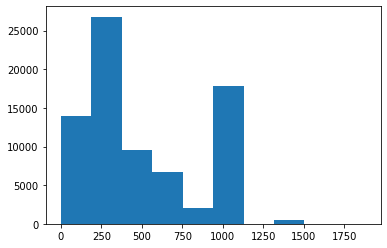

In [12]:
plt.hist(data_df['pause'])
plt.show()

In [10]:
train_ds, test_ds = train_test_split(data_df)

In [80]:
# tfidf = TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, token_pattern=None, max_features=10000)
# train_vec = tfidf.fit_transform(train_ds['sents'])
# test_vec = tfidf.transform(test_ds['sents'])

# cls_pause = CatBoostRegressor(iterations=1000,
#                           learning_rate=0.1,
#                           depth=6, l2_leaf_reg=0.2)
# cls_pause.fit(train_vec, train_ds['pause'])
# #cls_pause.fit(test_embs, test_ds['pause'])
# y = cls_pause.predict(test_vec)
# print(np.sqrt(mean_squared_error(test_ds['pause'], y))) # 156



# test_lens = np.array([len(s) for s in test_ds['sents']]).reshape(-1,1)
# test_lens //= test_lens.max() 

# train_f = np.concatenate((test_vec.toarray(), test_lens), axis=1)
# #cls_pause = MultinomialNB()
# cls_pause = LinearRegression()
# #cls_pause.fit(train_vec, train_ds['pause']//100)
# cls_pause.fit(train_f, test_ds['pause'])
# y = cls_pause.predict(train_f)
# print(((test_ds['pause']- y)**2).mean())
# plt.plot(test_ds['pause'], y, 'o')

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer).shape)
# (312,)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(312,)


In [14]:
test_embs = [embed_bert_cls(' '.join(s), model, tokenizer) for s in test_ds['sents']]

In [15]:
train_embs = [embed_bert_cls(' '.join(s), model, tokenizer) for s in train_ds['sents']]

In [27]:
np.sqrt(mean_squared_error(test_ds['pause'].values, np.array([test_ds['pause'].mean()]*len(test_ds['pause']))))

341.9744757993712

In [145]:
cls_pause = CatBoostRegressor(iterations=5000,
                          learning_rate=0.05,
                          depth=6) #l2_leaf_reg=0.2)
cls_pause.fit(train_embs, train_ds['pause'])
#cls_pause.fit(test_embs, test_ds['pause'])
y = cls_pause.predict(test_embs)
print(np.sqrt(mean_squared_error(test_ds['pause'], y)))
#print(np.sqrt((test_ds['pause'] - y)**2).mean())
# 310, 1, 3, | 150    
# 310, 0.9, 3, | 149 
# 310, 0.5, 4, | 143.2
# 610, 0.1, 4, | 143.4
# 610, 0.2, 4, | 138.8
# 610, 0.3, 4, | 139.0
# 610, 0.25, 4, | 138.7
# 1000, 0.25, 4, | 136.8
# 1000, 0.3, 5, | 136.7
# 2000, 0.25, 5, | 135.8
# 5000, 0.1, 5, | 131.3
# 5000, 0.05, 6 | 129.1/ 169.1

# grid = {'iterations': [200],
#         'learning_rate': [0.03, 0.1],
#         'depth': [6],
#         'l2_leaf_reg': [0.2, 0.5, 1, 3]}
# cls_pause.grid_search(grid, catboost.Pool(train_embs, train_ds['pause']))
# #                          params': {'depth': 6,
# #  'iterations': 200,
# #  'learning_rate': 0.1,
# #  'l2_leaf_reg': 0.2},


0:	learn: 336.9825288	total: 23ms	remaining: 1m 55s
1:	learn: 330.8995493	total: 46.4ms	remaining: 1m 55s
2:	learn: 325.1848753	total: 70.4ms	remaining: 1m 57s
3:	learn: 319.7784116	total: 93.8ms	remaining: 1m 57s
4:	learn: 314.7256881	total: 117ms	remaining: 1m 56s
5:	learn: 310.0333877	total: 141ms	remaining: 1m 57s
6:	learn: 305.5252498	total: 165ms	remaining: 1m 57s
7:	learn: 301.2562761	total: 188ms	remaining: 1m 57s
8:	learn: 297.3423466	total: 211ms	remaining: 1m 57s
9:	learn: 293.7832588	total: 237ms	remaining: 1m 58s
10:	learn: 290.2563883	total: 260ms	remaining: 1m 57s
11:	learn: 286.8313080	total: 285ms	remaining: 1m 58s
12:	learn: 283.6604357	total: 308ms	remaining: 1m 58s
13:	learn: 280.6802331	total: 331ms	remaining: 1m 57s
14:	learn: 277.9003349	total: 354ms	remaining: 1m 57s
15:	learn: 275.2377010	total: 378ms	remaining: 1m 57s
16:	learn: 272.6637395	total: 401ms	remaining: 1m 57s
17:	learn: 270.3961882	total: 424ms	remaining: 1m 57s
18:	learn: 268.1755101	total: 447ms	

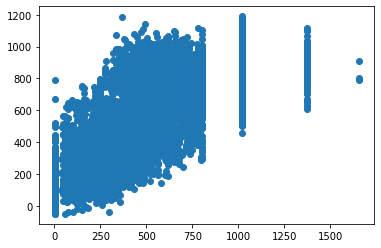

In [146]:
plt.plot(test_ds['pause'], y, 'o')

In [36]:
print(np.sqrt((test_ds['pause'] - y)**2).mean())


129.15563685545044


In [43]:
def get_pos_feats(ds):
    return ds.apply(lambda x: [(i, len(x['sents'])-i) for i, s in enumerate(x['sents'])], axis=1)
        
train_ds['pos'] = get_pos_feats(train_ds)
test_ds['pos'] = get_pos_feats(test_ds)


In [45]:
train_ds.head()

,sents,pause,nucleus,pos
53374,"[А, самое, главное, ,]",275,"[False, False, True, False]","[(0, 4), (1, 3), (2, 2), (3, 1)]"
37659,"[Залог, крепкой, онлайн-дружбы, -]",216,"[False, False, True, False]","[(0, 4), (1, 3), (2, 2), (3, 1)]"
60268,"[надо, сделать, что, ?]",668,"[False, False, True, False]","[(0, 4), (1, 3), (2, 2), (3, 1)]"
45833,"[А, вдруг, на, кассе, после, оплаты, мне, скаж...",332,"[False, False, False, False, False, False, Fal...","[(0, 9), (1, 8), (2, 7), (3, 6), (4, 5), (5, 4..."
64999,"[когда, можно, спасти, мир, ,]",359,"[False, False, False, True, False]","[(0, 5), (1, 4), (2, 3), (3, 2), (4, 1)]"


In [104]:
train_pos = np.concatenate(train_ds['pos'].values)
train_nucleus_y =  np.concatenate(train_ds['nucleus'].values).astype(int)
train_pos = train_pos / train_pos.max(axis=0) 

test_pos = np.concatenate(test_ds['pos'].values) / train_pos.max(axis=0) 
test_nucleus_y =  np.concatenate(test_ds['nucleus'].values).astype(int)

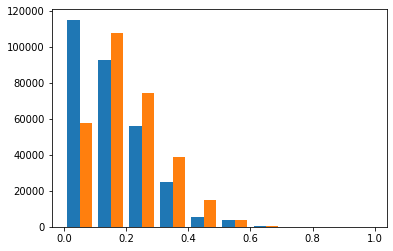

(array([241759.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  57003.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

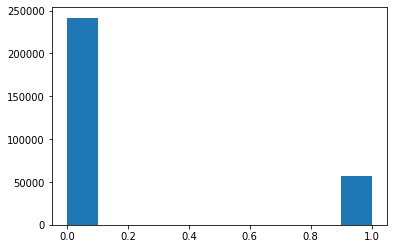

In [165]:
plt.hist(train_pos)
plt.show()
plt.hist(train_nucleus_y)

In [212]:
c = CountVectorizer(tokenizer = lambda x:x, lowercase=False, token_pattern=None, max_features=100)
c.fit(train_ds['sents'])


CountVectorizer(lowercase=False, max_features=100, token_pattern=None,
                tokenizer=<function <lambda> at 0x7f82d9672af0>)

In [215]:
c.transform(['я']).shape

(1, 100)

In [116]:
# pca = sklearn.decomposition.PCA(10)
# pca.fit(train_embs)

PCA(n_components=10)

In [225]:
c.transform([[w] for s in  test_ds['sents'] for w in s]).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [221]:
test_pos.shape

(99516, 2)

In [227]:
# train_pos_embs = np.concatenate((train_pos, np.concatenate([pca.transform(np.tile(train_embs[i:i+1], [len(s), 1])) for i, s in  enumerate(train_ds['sents'])])), axis=1)
# test_pos_embs = np.concatenate((test_pos, np.concatenate([pca.transform(np.tile(test_embs[i:i+1], [len(s), 1])) for i, s in  enumerate(test_ds['sents'])])), axis=1)
train_pos_embs = np.concatenate((train_pos, c.transform([[w] for s in  train_ds['sents'] for w in s]).toarray()), axis=1)
test_pos_embs = np.concatenate((test_pos, c.transform([[w] for s in  test_ds['sents'] for w in s]).toarray()), axis=1)
test_pos_embs

array([[0., 6., 0., ..., 0., 0., 0.],
       [1., 5., 0., ..., 0., 0., 0.],
       [2., 4., 0., ..., 0., 0., 0.],
       ...,
       [0., 3., 0., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [2., 1., 0., ..., 0., 0., 0.]])

In [228]:
# cls_stress = CatBoostClassifier(iterations=100,
#                           learning_rate=0.001,
#                           depth=4, auto_class_weights='SqrtBalanced') #)
cls_stress = sklearn.pipeline.Pipeline((('n', MinMaxScaler()), ('c', MultinomialNB())))
cls_stress.fit(train_pos_embs, train_nucleus_y)
y = cls_stress.predict(test_pos_embs)
print(sklearn.metrics.classification_report(test_nucleus_y, y))

              precision    recall  f1-score   support

           0       0.89      0.51      0.65     80543
           1       0.26      0.74      0.39     18973

    accuracy                           0.55     99516
   macro avg       0.58      0.62      0.52     99516
weighted avg       0.77      0.55      0.60     99516



In [138]:
with open('data/TTS_Prosodic_Result.json') as f:
    pub_test = json.load(f)

pub_df={'words':[], 'nucleus':[], 'pause':[], 'sent':[]}
s_id=0
for s in pub_test:
    for e in s['words']:
        pub_df['words'].append(e['content'])
        pub_df['nucleus'].append(e['phrasal_stress'])
        pause = e['pause_len'] if e['pause_len'] > 0 else 0
        pub_df['pause'].append(pause)
        pub_df['sent'].append(s_id)
        if pause > 0 :
            s_id+=1

pub_df= pd.DataFrame(pub_df)
pub_df.head()

,words,nucleus,pause,sent
0,Я,False,0,0
1,встречусь,True,0,0
2,с,False,0,0
3,"ним,",False,269,0
4,когда,False,0,1


In [140]:
# words	nucleus	pause	sent
pub_data_df = convert_to_tokenized(pub_df)
pub_data_df.head()

,sents,pause,nucleus
0,"[Я, встречусь, с, ним, ,]",269,"[False, True, False, False, False]"
1,"[когда, он, вернется, .]",795,"[False, False, True, False]"
2,"[Большое, спасибо, ,]",334,"[False, True, False]"
3,"[но, мне, пора, .]",692,"[False, False, True, False]"
4,"[Ты, полагаешь, ,]",177,"[False, True, False]"


In [141]:
pub_test_embs = [embed_bert_cls(' '.join(s), model, tokenizer) for s in pub_data_df['sents']]

In [156]:
y = cls_pause.predict(pub_test_embs)
print(np.stack((y, pub_data_df['pause'].values), axis=1))
print(np.sqrt(mean_squared_error(pub_data_df['pause'], y)))

[[218.47728706 269.        ]
 [965.61699279 795.        ]
 [313.57119777 334.        ]
 [961.34860732 692.        ]
 [260.0810046  177.        ]
 [324.78148953 354.        ]
 [316.82524347 178.        ]
 [892.05230904 683.        ]
 [123.29262491 305.        ]
 [960.45674585 622.        ]
 [257.5638665  290.        ]
 [109.16104212 287.        ]
 [912.87722056 300.        ]]
237.1672609951769


In [200]:
pub_data_df['pos'] = get_pos_feats(pub_data_df)
pub_pos = np.concatenate(pub_data_df['pos'].values) / train_pos.max(axis=0) 
pub_nucleus_y =  np.concatenate(pub_data_df['nucleus'].values).astype(int)
pub_sents = np.array([i for i, s in enumerate(pub_data_df['nucleus']) for _ in s])
    
#pub_pos_embs = np.concatenate((pub_pos, np.concatenate([pca.transform(np.tile(pub_test_embs[i:i+1], [len(s), 1])) for i, s in  enumerate(pub_data_df['sents'])])), axis=1)
pub_pos_embs = np.concatenate((pub_pos, c.transform([[w] for s in  pub_data_df['sents'] for w in s]).toarray()), axis=1)

In [201]:
pub_sents

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12])

In [237]:
p = cls_stress.predict_proba(pub_pos_embs)[:, 1]

y=[]
for i in range(pub_sents.max()+1):
    p_s = p[pub_sents==i]
    y_s = np.zeros(len(p_s))
    y_s[p_s.argmax()] = 1
    y.append(y_s)
y = np.concatenate(y)

print(y.shape)
print(pub_nucleus_y.shape)
print(np.stack((y, pub_nucleus_y), axis=1))
print(sklearn.metrics.classification_report(pub_nucleus_y, y))

(67,)
(67,)
[[0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.85      0.85      0.85        13

    accuracy                           0.94        67
   macro avg       0.90      0.90      0.90        67
weighted avg       0.94      0.94      0.94        67



In [252]:
def load_test_xml(path):
    data_xml = ET.parse(path)
    root = data_xml.getroot()

    for child in root.findall('text/sentence/word'):
        print(child.tag, child.attrib, child.text)
    sentences = root.findall('.//sentence')
    dataset = []
    sentagma_id=0
    for sen in sentences:
        sent = []
        sentagma
        for item in sen:
            if item.tag == 'word':
                if 'original' not in item.attrib:
                    continue
                sent.append(item.attrib['original'])   
                if last_word:
                    last_word=False
                    sent=[]
            elif item.tag == 'content' and 'PunktEnd' in item.attrib:
                last_word = True
                continue
                
        dataset.append({'words': sent})

        
    return dataset

test_private = load_test_xml('data/Test_private.xml')
#convert_to_tokenized(pd.DataFrame({'sents': test_private_tok


test_private_tok = [[t.text for w in s for t in tokenize(w)] for s in test_private]


In [257]:
test_private_ds = pd.DataFrame({'sents': test_private_tok})
test_private_ds.head()

,sents
0,"[Реально, начать, день, с, улыбки, -]"
1,"[это, проснуться, от, звонка, будильника, в, о..."
2,"[широко, улыбнуться, и, спать, дальше, .]"
3,"[Согласитесь, ,]"
4,"[было, бы, гораздо, лучше, ,]"


In [254]:
test_private_tok_embs = [embed_bert_cls(' '.join(s), model, tokenizer) for s in test_private_tok]

In [255]:
test_private_pauses = cls_pause.predict(test_private_tok_embs)

In [274]:
test_private_ds['pause'] = test_private_pauses

In [262]:
test_private_ds['pos'] = get_pos_feats(test_private_ds)
test_private_sents = np.array([i for i, s in enumerate(test_private_ds['sents']) for _ in s])

test_private_pos = np.concatenate(test_private_ds['pos'].values) / train_pos.max(axis=0) 
test_private_pos_embs = np.concatenate((test_private_pos, c.transform([[w] for s in  test_private_ds['sents'] for w in s]).toarray()), axis=1)
test_private_pos_embs[:1]

array([[0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [271]:
test_private_sents[:20]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [277]:
private_p = cls_stress.predict_proba(test_private_pos_embs)[:, 1]

private_y=[]
for i in range(test_private_sents.max()+1):
    p_s = private_p[test_private_sents==i]
    y_s = np.zeros(len(p_s))
    y_s[p_s.argmax()] = 1
    private_y.append(y_s)
#private_y = np.concatenate(private_y)

print(len(private_y))

664


In [278]:
test_private_ds['nucleus'] = private_y

In [279]:
test_private_ds.head()

,sents,pos,pause,nucleus
0,"[Реально, начать, день, с, улыбки, -]","[(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1)]",349.189623,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[это, проснуться, от, звонка, будильника, в, о...","[(0, 11), (1, 10), (2, 9), (3, 8), (4, 7), (5,...",294.928616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[широко, улыбнуться, и, спать, дальше, .]","[(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1)]",955.695603,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,"[Согласитесь, ,]","[(0, 2), (1, 1)]",208.359479,"[1.0, 0.0]"
4,"[было, бы, гораздо, лучше, ,]","[(0, 5), (1, 4), (2, 3), (3, 2), (4, 1)]",281.325108,"[0.0, 0.0, 0.0, 1.0, 0.0]"


In [291]:
def to_json():
    out = [] 
    for row_i, row in test_private_ds.iterrows():
        #print(row)
        words = [{'content': w, 
                  'phrasal_stress': n, 
                  'pause_len': -1}  for w, n in zip(row['sents'][:-1], row['nucleus'][:-1])]
        if len(words) == 0:
            words.append({'content': row['sents'][-1], 
                  'phrasal_stress': True, 
                  'pause_len': row['pause']})
        else:
            words[-1]['content']+=row['sents'][-1]
            words[-1]['pause_len'] = row['pause']
            words[-1]['phrasal_stress'] = words[-1]['phrasal_stress'] or row['nucleus'][-1]
        out.append({'words': words})
    return out

with open('data/mitrofanov_submit.json', 'w', encoding='utf-8') as f:
    json.dump(to_json(), f, ensure_ascii=False)
      

In [285]:
['Наконец-то'][-1]

'Наконец-то'